*Made By [Adnan](https://linktr.ee/adnaaaen)*

# ***Model Building***

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

import os
import joblib
from warnings import filterwarnings

plt.style.use("dark_background")
filterwarnings("ignore")

In [2]:
if not os.path.exists("../data/preprocessed/preprocessed.csv"):
    raise FileNotFoundError(
        "preprocessed dataset is not here, please run the 03-preprocessed.ipynb notebook"
    )

df = pd.read_csv("../data/preprocessed/preprocessed.csv")
df.head()

,city_0,city_1,city_2,city_3,city_4,pm2.5,pm10,no,no2,n_ox,nh3,co,so2,o3,benzene,toluene,is_weekend,day_time,season,aqi
0,-0.815813,-0.925448,-0.990663,-0.847216,0.76235,0.644657,0.050355,-1.393542,0.086050,0.033354,-0.002545,0.239407,1.479066,0.701922,-1.117163,-1.479028,-0.632988,-1.616656,-1.329244,5.666427
1,-0.815813,-0.925448,-0.990663,-0.847216,0.76235,0.746076,0.050355,-1.170187,-0.022855,0.105121,-0.002545,0.604834,2.566772,-0.127273,-1.117163,-1.479028,-0.632988,-0.934937,-1.329244,5.204007
2,-0.815813,-0.925448,-0.990663,-0.847216,0.76235,0.781722,0.050355,-1.277426,-0.009440,0.100697,-0.002545,0.429382,2.804722,1.112832,-1.117163,-1.479028,-0.632988,-0.934937,-1.329244,5.209486
3,-0.815813,-0.925448,-0.990663,-0.847216,0.76235,0.688063,0.050355,-1.715616,-0.239575,-0.185967,-0.002545,-0.287535,1.878814,1.417043,-1.117163,-1.479028,-0.632988,-0.934937,-1.329244,5.209486
4,-0.815813,-0.925448,-0.990663,-0.847216,0.76235,0.455894,0.050355,-1.817152,-0.431640,-0.450823,-0.002545,-0.453657,1.562342,1.721293,-1.117163,-1.479028,-0.632988,-0.253217,-1.329244,5.192957


### ***Fearure - Target split***

In [3]:
X = df.drop(["aqi"], axis=1)
Y = df["aqi"]

(X.shape), (Y.shape)

((568424, 19), (568424,))

### ***Train Test Split***

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, random_state=323987, shuffle=True, test_size=0.3
)

(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((397896, 19), (397896,)), ((170528, 19), (170528,)))

### ***Model Building***

In [5]:
"""chooe LinearRegression as Model"""

lr = LinearRegression()
regressor_model = lr.fit(x_train, y_train)

In [6]:
"""predict train set"""

y_train_pred = regressor_model.predict(x_train)

# evaluation metrics
train_mae = mean_absolute_error(y_train_pred, y_train)
train_mse = mean_squared_error(y_train_pred, y_train)
train_r_square = r2_score(y_train_pred, y_train)

In [7]:
"""predict test set"""

y_pred = regressor_model.predict(x_test)

# evalucation metrics
test_mae = mean_absolute_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_r_square = r2_score(y_test, y_pred)

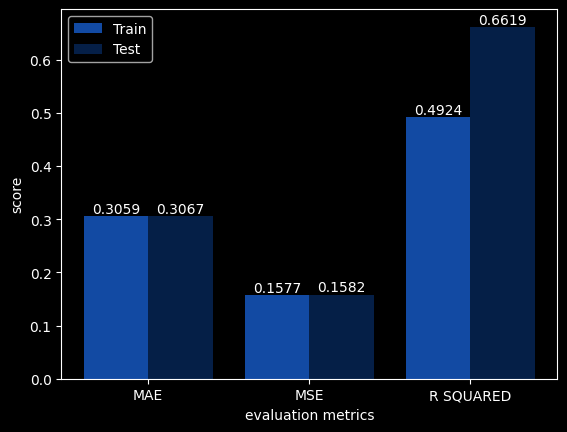

In [8]:
"""plot the metrics in train and test sets, to check overfit/underfit"""

x = ["MAE", "MSE", "R SQUARED"]
x_axis = np.arange(len(x))

ax_1 = plt.bar(
    x_axis - 0.2,
    [train_mae, train_mse, train_r_square],
    0.4,
    label="Train",
    color="#124aa3",
)
ax_2 = plt.bar(
    x_axis + 0.2,
    [test_mae, test_mse, test_r_square],
    0.4,
    label="Test",
    color="#051f47",
)

plt.bar_label(ax_1, fmt="%.4f")
plt.bar_label(ax_2, fmt="%.4f")
plt.ylabel("score")
plt.xlabel("evaluation metrics")
plt.xticks(x_axis, x)
plt.legend()
plt.show()

In [9]:
"""save model as serialized joblib file"""

if not os.path.exists("../model/trained"):
    os.mkdir("../model/trained")

joblib.dump(regressor_model, "../model/trained/linear_regression_model.joblib")

['../model/trained/linear_regression_model.joblib']

### ***Next: Create Flask Dashboard***